# GEE Classification Data Visualization

This notebook visualizes the training data for a land cover classification project using Earth Engine data. The data contains spectral bands (B2, B3, B4, B8), NDVI values, and land cover classifications.

In [6]:
%pip install folium seaborn pandas matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')  # Updated style name for newer matplotlib versions
sns.set_context("notebook", font_scale=1.2)

In [9]:
# Load the training data
train_data = pd.read_csv('/Users/Dhruv/gee_classificaTION/train_data.csv')

# Display the first few rows of the dataset
train_data.head()

,system:index,B2,B3,B4,B8,NDVI,landcover,random,.geo
0,1_1_0_0,0.08595,0.09060,0.08510,0.1398,0.243219,0,0.200726,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_0_1,0.08325,0.08530,0.07770,0.1371,0.276536,0,0.525565,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_0_2,0.07865,0.08725,0.07775,0.1351,0.269439,0,0.669644,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_0_3,0.08495,0.09445,0.08970,0.1474,0.243357,0,0.492457,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_0_5,0.10910,0.12110,0.12180,0.1861,0.208834,0,0.687153,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [10]:
# Examine basic statistics of the dataset
print(f"Dataset Shape: {train_data.shape}")
print(f"\nLand Cover Classes:")
print(train_data['landcover'].value_counts())

# Display summary statistics for the spectral bands
train_data[['B2', 'B3', 'B4', 'B8', 'NDVI']].describe()

Dataset Shape: (273, 9)

Land Cover Classes:
landcover
2    109
1     84
0     80
Name: count, dtype: int64


,B2,B3,B4,B8,NDVI
count,273.000000,273.000000,273.000000,273.000000,273.000000
mean,0.070294,0.072049,0.063670,0.074225,0.032994
std,0.018120,0.020557,0.024573,0.042069,0.148373
min,0.051650,0.053700,0.039800,0.032500,-0.141439
25%,0.058400,0.058400,0.046400,0.037100,-0.108023
50%,0.061000,0.061100,0.054850,0.061350,0.027629
75%,0.077100,0.079150,0.068400,0.095100,0.111966
max,0.150600,0.161900,0.173700,0.209800,0.378712


## Extracting Coordinates

Since the `.geo` column contains empty coordinate arrays, we'll need to extract location information from the `system:index` field. This field typically contains encoded information about the location of the pixels in Earth Engine.

In [11]:
# Parse system:index to extract any potential coordinate information
# Format appears to be like '1_1_0_4', which might encode row/column information

def parse_index(idx):
    parts = idx.split('_')
    # This is a simplistic approach - you may need to adjust based on actual encoding
    if len(parts) >= 3:
        return {
            'group': int(parts[0]),
            'subgroup': int(parts[1]),
            'row': int(parts[2]),
            'col': int(parts[3]) if len(parts) > 3 else 0
        }
    return None

# Apply parsing to create pseudo-coordinates
parsed_indices = train_data['system:index'].apply(parse_index)
train_data['group'] = parsed_indices.apply(lambda x: x['group'] if x else None)
train_data['subgroup'] = parsed_indices.apply(lambda x: x['subgroup'] if x else None)
train_data['row'] = parsed_indices.apply(lambda x: x['row'] if x else None)
train_data['col'] = parsed_indices.apply(lambda x: x['col'] if x else None)

# Create pseudo-coordinates for visualization
# This is a simplistic approach assuming the indices encode some spatial relationship
train_data['pseudo_x'] = train_data['col']
train_data['pseudo_y'] = train_data['row']

# Check results
train_data[['system:index', 'group', 'subgroup', 'row', 'col', 'pseudo_x', 'pseudo_y']].head()

,system:index,group,subgroup,row,col,pseudo_x,pseudo_y
0,1_1_0_0,1,1,0,0,0,0
1,1_1_0_1,1,1,0,1,1,0
2,1_1_0_2,1,1,0,2,2,0
3,1_1_0_3,1,1,0,3,3,0
4,1_1_0_5,1,1,0,5,5,0


## Spectral Band Visualization

Let's create visualizations of the spectral characteristics by landcover class.

/var/folders/y0/3mnzwcmn4qdft7rhhv9ppgtc0000gp/T/ipykernel_30750/1575351084.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='landcover', y=band, data=train_data, palette=landcover_colors, ax=axes[i])
/var/folders/y0/3mnzwcmn4qdft7rhhv9ppgtc0000gp/T/ipykernel_30750/1575351084.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='landcover', y=band, data=train_data, palette=landcover_colors, ax=axes[i])
/var/folders/y0/3mnzwcmn4qdft7rhhv9ppgtc0000gp/T/ipykernel_30750/1575351084.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='l

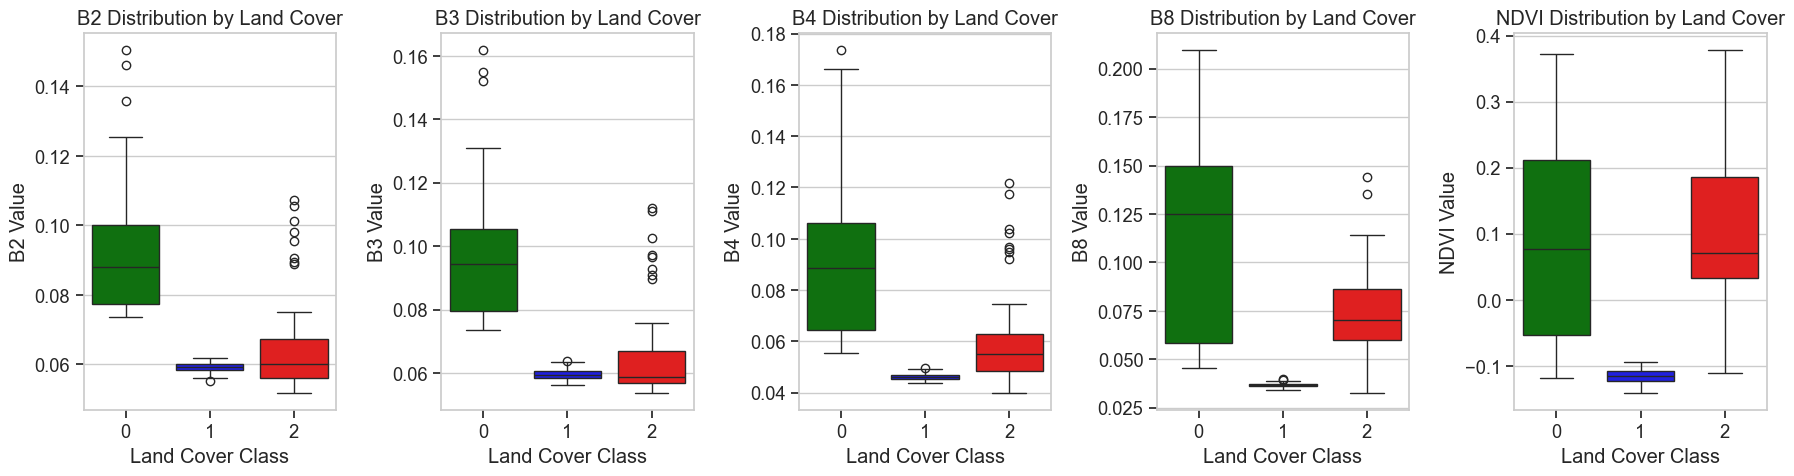

In [13]:
# Define color palette for the landcover classes (keys as strings for seaborn compatibility)
landcover_colors = {'0': 'green', '1': 'blue', '2': 'red'}
landcover_names = {0: 'Class 0 (Vegetation)', 1: 'Class 1 (Water)', 2: 'Class 2 (Urban)'}

# Create boxplots for each spectral band by landcover class
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
bands = ['B2', 'B3', 'B4', 'B8', 'NDVI']

for i, band in enumerate(bands):
    sns.boxplot(x='landcover', y=band, data=train_data, palette=landcover_colors, ax=axes[i])
    axes[i].set_title(f'{band} Distribution by Land Cover')
    axes[i].set_xlabel('Land Cover Class')
    axes[i].set_ylabel(band+' Value')

plt.tight_layout()
plt.show()

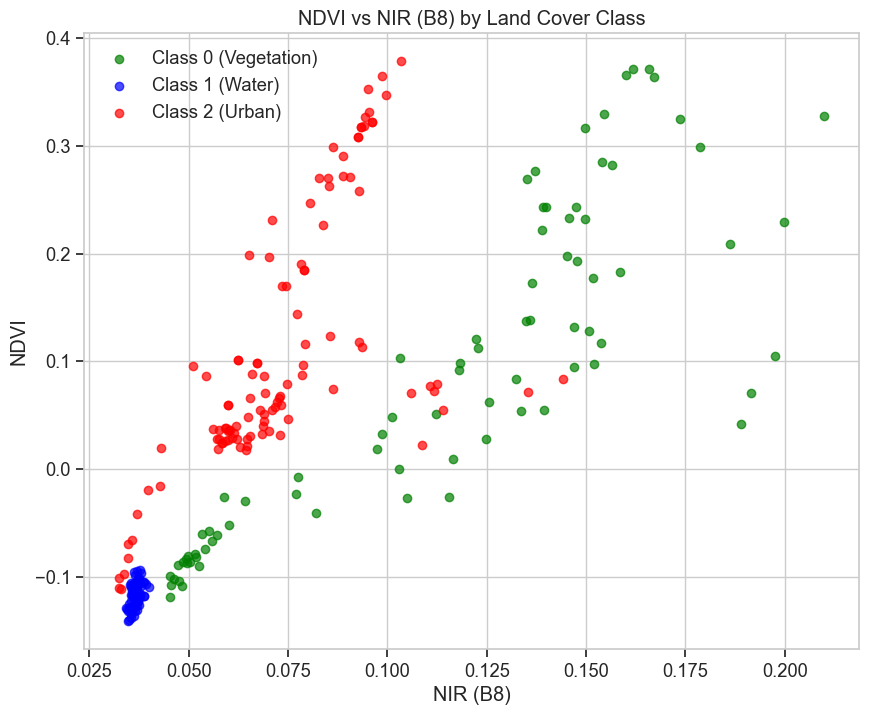

In [15]:
# Create a scatter plot of NDVI vs B8 (NIR) colored by landcover class
plt.figure(figsize=(10, 8))
for landcover_str, color in landcover_colors.items():
    landcover = int(landcover_str)
    mask = train_data['landcover'] == landcover
    plt.scatter(train_data.loc[mask, 'B8'], 
                train_data.loc[mask, 'NDVI'], 
                c=color, 
                label=landcover_names[landcover],
                alpha=0.7)

plt.title('NDVI vs NIR (B8) by Land Cover Class')
plt.xlabel('NIR (B8)')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.show()

## Spatial Distribution Visualization

Using the pseudo-coordinates extracted from the index, we'll create a spatial visualization of the data points.

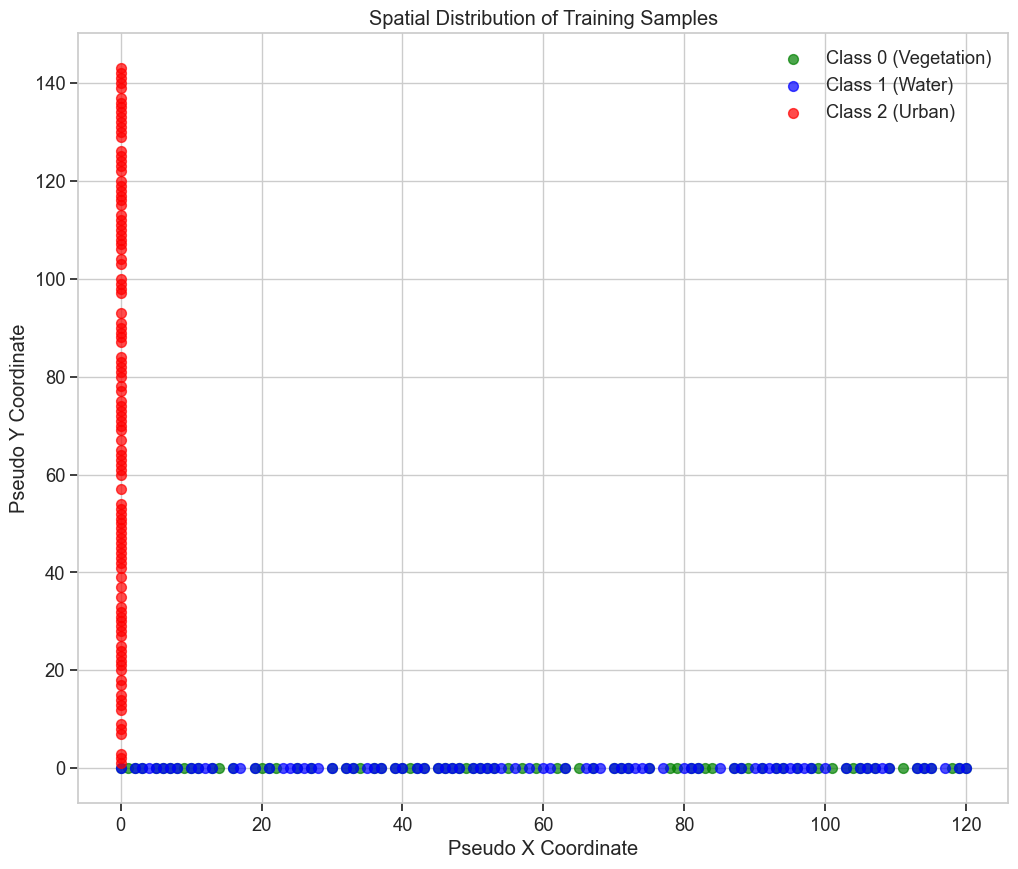

In [17]:
# Create a scatter plot showing the spatial distribution of samples
plt.figure(figsize=(12, 10))
for landcover_str, color in landcover_colors.items():
    landcover = int(landcover_str)
    mask = train_data['landcover'] == landcover
    plt.scatter(train_data.loc[mask, 'pseudo_x'], 
                train_data.loc[mask, 'pseudo_y'], 
                c=color, 
                label=landcover_names[landcover],
                alpha=0.7,
                s=50)

plt.title('Spatial Distribution of Training Samples')
plt.xlabel('Pseudo X Coordinate')
plt.ylabel('Pseudo Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

## Interactive Visualization with Plotly

Let's create an interactive 3D scatter plot to visualize the spectral space.

In [21]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install 'nbformat>=4.2.0' 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:


# Ensure nbformat is installed with correct version
import sys
import importlib.util
import importlib.metadata
import pandas as pd

# plotly.express is already imported as px in cell 2

if importlib.util.find_spec("nbformat") is None or importlib.metadata.version("nbformat") < "4.2.0":
    # Restart kernel may be needed after installation
    print("nbformat has been installed or updated. You may need to restart the kernel.")
# Check if train_data is defined, if not load it
if 'train_data' not in globals():
    # Load the training data
    train_data = pd.read_csv('/Users/Dhruv/gee_classificaTION/train_data.csv')

fig = px.scatter_3d(
    train_data, 
    x='B2', 
    y='B4', 
    z='NDVI',
    color='landcover',
    color_discrete_map={0: 'green', 1: 'blue', 2: 'red'},
    labels={'landcover': 'Land Cover Class'},
    title='3D Spectral Space Visualization'
)

fig.update_layout(
    scene=dict(
        xaxis_title='Blue Band (B2)',
        yaxis_title='Red Band (B4)',
        zaxis_title='NDVI'
    ),
    width=900,
    height=700
)

fig.show()

NameError: name 'px' is not defined

In [26]:
# Create a 2D map of the pseudo-coordinates colored by landcover
fig = px.scatter(
    train_data,
    x='pseudo_x',
    y='pseudo_y',
    color='landcover',
    color_discrete_map={0: 'green', 1: 'blue', 2: 'red'},
    labels={'landcover': 'Land Cover Class'},
    title='Land Cover Spatial Distribution',
    hover_data=['B2', 'B3', 'B4', 'B8', 'NDVI']
)

fig.update_layout(
    xaxis_title='X Coordinate',
    yaxis_title='Y Coordinate',
    width=900,
    height=700
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## NDVI Analysis by Land Cover Class

Let's analyze the NDVI distribution for each land cover class.

In [ ]:
# Create a violin plot of NDVI by landcover class
plt.figure(figsize=(12, 6))
sns.violinplot(x='landcover', y='NDVI', data=train_data, palette=landcover_colors)
plt.title('NDVI Distribution by Land Cover Class')
plt.xlabel('Land Cover Class')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

# Calculate and display mean NDVI by class
ndvi_by_class = train_data.groupby('landcover')['NDVI'].agg(['mean', 'std', 'min', 'max'])
ndvi_by_class

## Comparison with Validation Data

Let's load the validation data and compare it with the training data.

In [ ]:
# Load validation data
val_data = pd.read_csv('/Users/Dhruv/gee_classificaTION/val_data.csv')

# Add a dataset column to distinguish between training and validation data
train_data['dataset'] = 'Training'
val_data['dataset'] = 'Validation'

# Combine datasets for comparison
combined_data = pd.concat([train_data, val_data])

# Create a plot comparing NDVI distributions in training and validation sets
plt.figure(figsize=(14, 6))

for i, dataset in enumerate(['Training', 'Validation']):
    for landcover, color in landcover_colors.items():
        mask = (combined_data['dataset'] == dataset) & (combined_data['landcover'] == landcover)
        plt.subplot(1, 2, i+1)
        sns.kdeplot(combined_data.loc[mask, 'NDVI'], color=color, 
                   label=f'Class {landcover}', fill=True, alpha=0.3)
        plt.title(f'NDVI Distribution - {dataset} Data')
        plt.xlabel('NDVI')
        plt.ylabel('Density')
        plt.legend()

plt.tight_layout()
plt.show()

## Spectral Band Correlations

Let's examine the correlations between different spectral bands.

In [ ]:
# Calculate correlation matrix for spectral bands
corr_matrix = train_data[['B2', 'B3', 'B4', 'B8', 'NDVI']].corr()

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Spectral Bands')
plt.tight_layout()
plt.show()

## Conclusion

This notebook has explored the spectral characteristics of the training data for land cover classification. The visualizations show the relationships between different spectral bands and how they vary across land cover classes.

Key observations:
1. The three land cover classes show distinct spectral signatures
2. NDVI is a strong discriminator between vegetation and non-vegetation classes
3. The spatial distribution of samples provides insights into the geographic patterns of land cover